# Production

In this notebook we analyze the results of our best model.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

## metrics
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, 
                            ConfusionMatrixDisplay, plot_roc_curve, roc_auc_score, classification_report, RocCurveDisplay)

In [19]:
# recovering data
%store -r stored_data

## Baseline Model

Let's create a baseline model to compare our results.

In [8]:
dc = DummyClassifier()

In [604]:
with warnings.catch_warnings(record=True): #ignore warnings
    make_model(dc, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.7587506731287023
        Test Accuracy Score: 0.7592891760904685
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.0
        Specificity: 1.0
        Precision: 0.0
        
        Balance Accuracy: 0.5
        F1 Score: 0.0
        


- Regarding accuracy, 75.9% of our predictions correctly predicted if a posts belongs to `r/LifeProTips` or `r/lifehacks`.

- Regarding recall, the proportion of correctly predicted `r/lifehacks` posts over actual `r/lifehacks` posts. <br />
In this case we did not correctly predict any posts belong to `r/lifehacks`.

- Regarding specificity, the proportion of correctly predicted `r/LifeProTips` posts over actual `r/LifeProTips` posts. <br />
In this case we correctly predicted all `r/LifeProTips` posts that belong to `r/LifeProTips`.

- Regarding precision, the proportion of correct `r/lifehacks` predictions over all `r/lifehacks` predictions. <br />
Since we did not predict any post to belong to `r/lifehacks`, our precision score cannot be calculated (can't divide by zero). Defaults to zero instead.

- Our balanced accuracy score is the average of our recall and specificty score. It's important for us here because our data is imbalanced (far more cases of `r/LifeProTips` than `r/lifehacks`). <br />
Here we can see that our model is not doing a good job of predicting both classes correctly.

- Our F1 score is perhaps the most important metric here, because it measures the effects of recall and precision, the two most relevant metrics in our predictive model. </ br>
Since our recall was 0, our F1 score is 0 as well.

Given that our recall score is `0`, and our specifity score is `1`, our baseline model simply predicted all posts in the dataset to belong to `r/LifeProTips`! <br />
That means we incorrectly predicted about `30%` of our data, hence our accuracy score of 0.759.

## Best Model: Logistic Regression

In [36]:
best_model = stored_data['best_model']
X_train = stored_data['X_train_tf'] 
X_test = stored_data['X_test_tf']
y_train = stored_data['y_train_encoded']
y_test = stored_data['y_test_encoded']

In [37]:
preds = best_model.predict(X_test)

In [38]:
print(f'''
    Training Accuracy Score: {best_model.score(X_train, y_train)}
    Test Accuracy Score: {best_model.score(X_test, y_test)}
    
    --- Performance on unseen data ----
    Recall (Sensitivity): {recall_score(y_test, preds)}
    Specificity: {recall_score(y_test, preds, pos_label=0)}
    Precision: {precision_score(y_test, preds)}

    Balance Accuracy: {balanced_accuracy_score(y_test, preds)}
    F1 Score: {f1_score(y_test, preds)}
    ''')


    Training Accuracy Score: 0.9176090468497576
    Test Accuracy Score: 0.7463651050080775
    
    --- Performance on unseen data ----
    Recall (Sensitivity): 0.5906040268456376
    Specificity: 0.7957446808510639
    Precision: 0.4782608695652174

    Balance Accuracy: 0.6931743538483508
    F1 Score: 0.5285285285285286
    


This model performed the best in terms of recall and precision, which were our scores of interest given the imbalanced dataset. 

In [35]:
# model parameters
best_model.get_params()

{'C': 1,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 14,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

These were the hyperparameters that led to the strongest results, given our training features.

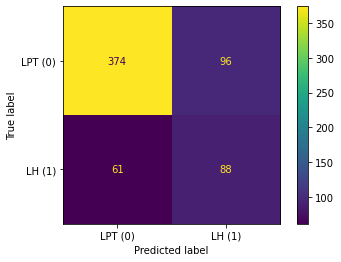

In [52]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels=['LPT (0)', 'LH (1)'])
#plt.savefig("../images/confusion_matrix.png");

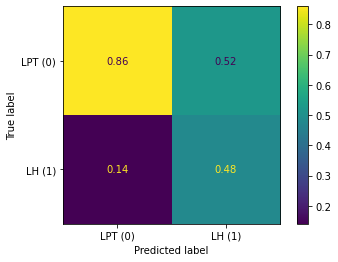

In [51]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels=['LPT (0)', 'LH (1)'], normalize='pred')
#plt.savefig("../images/confusion_matrix_props.png");

Due to the imbalanced data, the majority class (LPT) had strong correct prediction, and the minority class (LH) had less correct prediction. In fact, we had more incorrect LH prediction than correct predictions.

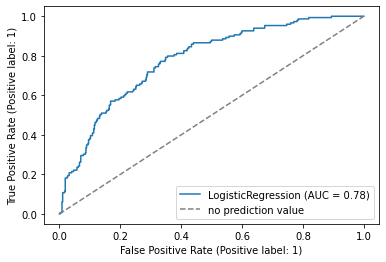

In [53]:
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.plot([0,1], [0,1], label='no prediction value', linestyle='--', color='gray') # add'worst case scenario' line
plt.legend()
#plt.savefig("../images/roc_curve.png");

Our ROC curve demonstrates that our model does fairly well at making correct LH post predictions. Performance starts to go down around the 0.8 true positive rate.

In [47]:
coefs = pd.DataFrame(best_model.coef_[0], index=X_train.columns)
lh_coefs = coefs.sort_values(by=0, ascending=False)[:10]
lpt_coefs = coefs.sort_values(by=0, ascending=True)[:10]

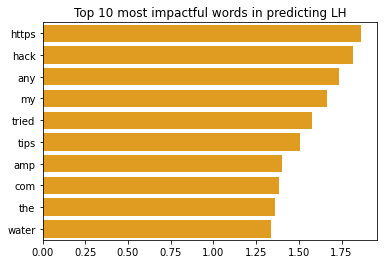

In [54]:
sns.barplot(y=lh_coefs.index, x=lh_coefs[0].values, orient='h', color='orange')
plt.title("Top 10 most impactful words in predicting LH")
#plt.savefig('../images/lh_coefs.png');

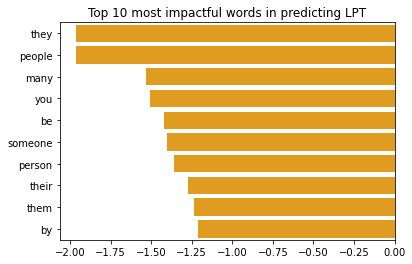

In [55]:
sns.barplot(y=lpt_coefs.index, x=lpt_coefs[0].values, orient='h', color='orange')
plt.title("Top 10 most impactful words in predicting LPT")
#plt.savefig('../images/lpt_coefs.png');

Interestingly enough, our top coefficients for predicting LH includes the word "tips" which is something we might expect to see more in LPT. We also notice that http is the top word in LH post, which might indicate that most submissions to LH include some type of hyperlink in the body text. Furthermore, LPT has more nouns and pronouns, perhaps indicating a more narrative-based submission style.